based on the tutorial found [here](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/ensembles/)

In [1]:
using Pkg
Pkg.add("PrettyPrinting")
Pkg.add("StableRNGs")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/gitRepos/ml-demos/Project.toml`
  No Changes to `~/gitRepos/ml-demos/Manifest.toml`
   Resolving package versions...
  No Changes to `~/gitRepos/ml-demos/Project.toml`
  No Changes to `~/gitRepos/ml-demos/Manifest.toml`


In [2]:
using MLJ 
import DataFrames: DataFrame 
using PrettyPrinting 
using StableRNGs

generate some dummy data

In [3]:
rng = StableRNG(42)
Xraw = rand(rng, 300, 3) 
y = exp.(Xraw[:1] .- Xraw[:, 2] .- 2Xraw[:,3] .+ 0.1*rand(rng,300))
X = DataFrame(Xraw, :auto)  # automatically generate column names

,x1,x2,x3
,Float64,Float64,Float64
1,0.580515,0.942777,0.100383
2,0.191241,0.427903,0.154318
3,0.971133,0.951418,0.528234
4,0.74345,0.920585,0.163011
5,0.170969,0.458709,0.969228
6,0.704776,0.898161,0.287235
7,0.441044,0.336018,0.324758
8,0.803972,0.719866,0.210357
9,0.772384,0.1361,0.481626


In [4]:
Pkg.add("NearestNeighborModels")

   Resolving package versions...
  No Changes to `~/gitRepos/ml-demos/Project.toml`
  No Changes to `~/gitRepos/ml-demos/Manifest.toml`


In [5]:
KNNRegressor = @load KNNRegressor

import NearestNeighborModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


NearestNeighborModels.KNNRegressor

In [6]:
knn_model = KNNRegressor(K=10)

KNNRegressor(
    K = 10,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = NearestNeighborModels.Uniform())

make a machine to wrap the data around the model 

In [7]:
knn = machine(knn_model, X, y)

Machine{KNNRegressor,…} trained 0 times; caches data
  args: 
    1:	Source @162 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @439 ⏎ `AbstractVector{Continuous}`


fit the model! 

In [8]:
train, test = partition(eachindex(y), 0.7);

fit!(knn, rows=train)
ŷ = predict(knn, X[test, :])
rms(ŷ, y[test])

┌ Info: Training Machine{KNNRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


0.08599648724198461

note: The few steps above are equivalent to just calling evaluate!

In [9]:
evaluate!(knn, resampling=Holdout(fraction_train=0.7), measure=rms)

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────┬─────────────┬───────────┬──────────┐
│ measure                │ measurement │ operation │ per_fold │
├────────────────────────┼─────────────┼───────────┼──────────┤
│ RootMeanSquaredError() │ 0.086       │ predict   │ [0.086]  │
└────────────────────────┴─────────────┴───────────┴──────────┘


# Homogenous Ensembles

There is basic support for simple ensembling strategies such as *bagging*.

We define so called *atomic* models that are then collected together into an ensemble

In [10]:
ensemble_model = EnsembleModel(atom=knn_model, n=20); # i.e. we have 20 atoms

In [11]:
ensemble = machine(ensemble_model, X, y)
estimates = evaluate!(ensemble, resampling=CV())

estimates

Evaluating over 6 folds: 100%[=========================] Time: 0:00:01


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────┬─────────────┬───────────┬────────────────────────────
│ measure                │ measurement │ operation │ per_fold                  ⋯
├────────────────────────┼─────────────┼───────────┼────────────────────────────
│ RootMeanSquaredError() │ 0.0811      │ predict   │ [0.0821, 0.0869, 0.0639,  ⋯
└────────────────────────┴─────────────┴───────────┴────────────────────────────
                                                                1 column omitted


# Systematic Tuning

Let's tune the ensemble's `bagging_fraction` and the K-Nearest neighbor hyperparameter `K`. **Note**: we have nested hyperparameters

In [12]:
params(ensemble_model) |> pprint

(atom = (K = 10,
         algorithm = :kdtree,
         metric = Distances.Euclidean(0.0),
         leafsize = 10,
         reorder = true,
         weights = NearestNeighborModels.Uniform()),
 atomic_weights = [],
 bagging_fraction = 0.8,
 rng = Random._GLOBAL_RNG(),
 n = 20,
 acceleration = CPU1{Nothing}(nothing),
 out_of_bag_measure = [])

define our tuning grid by constructing ranges for the two parameters

In [13]:
# bagging_fraction is how much of the dataset each atom sees
# K is the number of clusters we will use for predicting

B_range = range(ensemble_model, :bagging_fraction, lower=0.5, upper=1.0)
K_range = range(ensemble_model, :(atom.K), lower=1, upper=20)

NumericRange(1 ≤ atom.K ≤ 20; origin=10.5, unit=9.5)

define a `TunedModel` and fit it

In [14]:
tm = TunedModel(model=ensemble_model,
    tuning = Grid(resolution=10),  # a 10x10 grid
    resampling = Holdout(fraction_train=0.8, rng=StableRNG(42)),
    ranges=[B_range, K_range]
)

┌ Info: No measure specified. Setting measure=RootMeanSquaredError(). 
└ @ MLJTuning /home/john/.julia/packages/MLJTuning/bjRHJ/src/tuned_models.jl:308


DeterministicTunedModel(
    model = DeterministicEnsembleModel(
            atom = KNNRegressor,
            atomic_weights = Float64[],
            bagging_fraction = 0.8,
            rng = Random._GLOBAL_RNG(),
            n = 20,
            acceleration = CPU1{Nothing}(nothing),
            out_of_bag_measure = Any[]),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.8,
            shuffle = true,
            rng = StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)),
    measure = RootMeanSquaredError(),
    weights = nothing,
    operation = nothing,
    range = MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T[NumericRange(0.5 ≤ bagging_fraction ≤ 1.0; origin=0.75, unit=0.25), NumericRange(1 ≤ atom.K ≤ 20; origin=10.5, unit=9.5)],
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = tr

In [15]:
tuned_ensemble = machine(tm, X, y)
fit!(tuned_ensemble, rows=train);

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/john/.julia/packages/MLJTuning/bjRHJ/src/tuned_models.jl:680
Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:01


# Reporting results

we can access the best model: 

In [16]:
best_ensemble = fitted_params(tuned_ensemble).best_model
@show best_ensemble.atom.K
@show best_ensemble.bagging_fraction

best_ensemble.atom.K = 3
best_ensemble.bagging_fraction = 0.6111111111111112


0.6111111111111112

In [17]:
r = report(tuned_ensemble)

(best_model = DeterministicEnsembleModel{KNNRegressor},
 best_history_entry = (model = DeterministicEnsembleModel{KNNRegressor},
                       measure = [RootMeanSquaredError()],
                       measurement = [0.0803853093380962],
                       per_fold = [[0.0803853093380962]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold), Tuple{MLJEnsembles.DeterministicEnsembleModel{NearestNeighborModels.KNNRegressor}, Vector{RootMeanSquaredError}, Vector{Float64}, Vector{Vector{Float64}}}}[(model = DeterministicEnsembleModel{KNNRegressor}, measure = [RootMeanSquaredError()], measurement = [0.11148715528493755], per_fold = [[0.11148715528493755]]), (model = DeterministicEnsembleModel{KNNRegressor}, measure = [RootMeanSquaredError()], measurement = [0.1349157342949254], per_fold = [[0.1349157342949254]]), (model = DeterministicEnsembleModel{KNNRegressor}, measure = [RootMeanSquaredError()], measurement = [0.0999223839937471], per_fold = [[0.099922383993

In [18]:
using Plots

In [21]:
res = r.plotting 
vals_b = res.parameter_values[:, 1] 
vals_k = res.parameter_values[:,2]
loss = res.measurements

println(size(vals_b))
println(size(vals_k))
println(size(loss))

(100,)
(100,)
(100,)


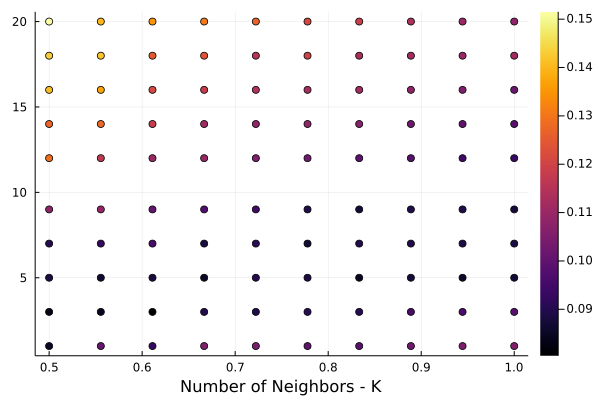

In [22]:
plot(vals_b, vals_k, zcolor=loss, seriestype=:scatter, label="")
xlabel!("Bagging Fraction")
xlabel!("Number of Neighbors - K")

Ideal we would make some kind of contourf to visualize this. We should look into making the matplotlib-style `tricontourf` function. 

Finally, we evaluate the model by reporting the `rms` on the test set.

In [23]:
ŷ = predict(tuned_ensemble, rows=test) 
rms(ŷ, y[test])

0.07657211488690698

# Example: Home-made random forest regressor for Boston dataset

Load data

In [25]:
import DataFrames: describe

In [26]:
X, y = @load_boston
sch = schema(X)
p = length(sch.names)
n = sch.nrows
@show (n, p)
describe(y)  # From DataFrames

(n, p) = (506, 12)
Summary Stats:
Length:         506
Missing Count:  0
Mean:           22.532806
Minimum:        5.000000
1st Quartile:   17.025000
Median:         21.200000
3rd Quartile:   25.000000
Maximum:        50.000000
Type:           Float64


load the decision tree regressor

In [27]:
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree


import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


MLJDecisionTreeInterface.DecisionTreeRegressor

Let's check the perforance of a single DTR 

In [29]:
tree = machine(DecisionTreeRegressor(), X, y) 
e = evaluate!(tree, resampling=Holdout(fraction_train=0.8), measure=[rms, rmslp1])

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌───────────────────────────────────────────────────┬─────────────┬─────────────
│ measure                                           │ measurement │ operation  ⋯
├───────────────────────────────────────────────────┼─────────────┼─────────────
│ RootMeanSquaredError()                            │ 7.06        │ predict    ⋯
│ RootMeanSquaredLogProportionalError(offset = 1.0) │ 0.328       │ predict    ⋯
└───────────────────────────────────────────────────┴─────────────┴─────────────
                                                                1 column omitted


## Random Forest

create an ensemble of DTR's and fix the number of subfeatures to 3 for now

In [30]:
forest = EnsembleModel(atom=DecisionTreeRegressor())
forest.atom.n_subfeatures = 3

3

let's evaluate the number of trees we need via a learning curve

In [31]:
rng = StableRNG(42) 
m = machine(forest, X, y) 

r = range(forest, :n, lower=10, upper=1000) 


curves = learning_curve!(m, resampling=Holdout(fraction_train=0.8, rng=rng),
                         range=r, measure=rms);

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /home/john/.julia/packages/MLJTuning/bjRHJ/src/tuned_models.jl:680
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:25


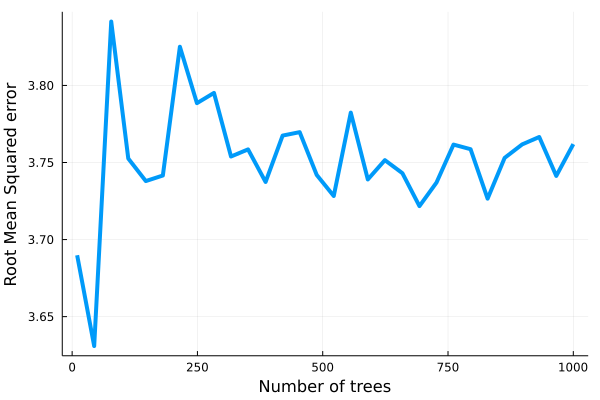

In [33]:
plot(curves.parameter_values, curves.measurements, linewidth=4,label="")
ylabel!("Root Mean Squared error", fontsize=16)
xlabel!("Number of trees", fontsize=16)

That's pretty noisy... 

## Tuning 

In [34]:
params(forest) |> pprint

(atom = (max_depth = -1,
         min_samples_leaf = 5,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 3,
         post_prune = false,
         merge_purity_threshold = 1.0,
         rng = Random._GLOBAL_RNG()),
 atomic_weights = [],
 bagging_fraction = 0.8,
 rng = Random._GLOBAL_RNG(),
 n = 100,
 acceleration = CPU1{Nothing}(nothing),
 out_of_bag_measure = [])

Let's try to tune the model using the number of subfeatures and the bagging fraction. 

In [35]:
r_sf = range(forest, :(atom.n_subfeatures), lower=1, upper=12)
r_bf = range(forest, :bagging_fraction, lower=0.4, upper=1.0)

NumericRange(0.4 ≤ bagging_fraction ≤ 1.0; origin=0.7, unit=0.3)

Now we build a tuned model to do a hyper-parameter search 

In [36]:
tuned_forest = TunedModel(model=forest,
                          tuning=Grid(resolution=5),
                          resampling=CV(nfolds=6, rng=StableRNG(32)),
                          ranges=[r_sf, r_bf],
                          measure=rms)
m = machine(tuned_forest, X, y)
e = evaluate!(m, resampling=Holdout(fraction_train=0.8),
              measure=[rms, rmslp1])
e

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌───────────────────────────────────────────────────┬─────────────┬─────────────
│ measure                                           │ measurement │ operation  ⋯
├───────────────────────────────────────────────────┼─────────────┼─────────────
│ RootMeanSquaredError()                            │ 4.0         │ predict    ⋯
│ RootMeanSquaredLogProportionalError(offset = 1.0) │ 0.259       │ predict    ⋯
└───────────────────────────────────────────────────┴─────────────┴─────────────
                                                                1 column omitted


In [42]:
fitted_params(tuned_forest).best_parameters

LoadError: MethodError: no method matching fitted_params(::MLJTuning.DeterministicTunedModel{Grid, MLJEnsembles.DeterministicEnsembleModel{MLJDecisionTreeInterface.DecisionTreeRegressor}})
[0mClosest candidates are:
[0m  fitted_params(::Union{MLJTuning.DeterministicTunedModel{T, M}, MLJTuning.ProbabilisticTunedModel{T, M}} where {T, M}, [91m::Any[39m) at ~/.julia/packages/MLJTuning/bjRHJ/src/tuned_models.jl:748
[0m  fitted_params(::MLJModelInterface.Model, [91m::Any[39m) at ~/.julia/packages/MLJModelInterface/txhfr/src/model_api.jl:101
[0m  fitted_params([91m::Union{Composite, Surrogate}[39m, [91m::Node[39m) at ~/.julia/packages/MLJBase/QXObv/src/composition/models/methods.jl:14
[0m  ...

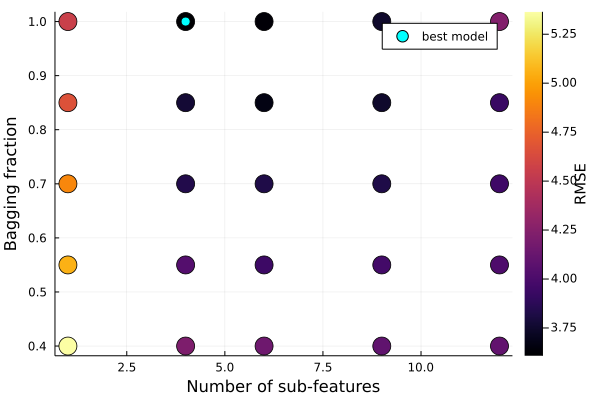

In [57]:
r = report(m); 

res = r.plotting

vals_sf = res.parameter_values[:,1] 
vals_bf=  res.parameter_values[:,2]

plot(vals_sf, vals_bf, seriestype=:scatter, zcolor=res.measurements, ms=10, label="", colorbar_title="RMSE")
plot!([r.best_model.atom.n_subfeatures], [r.best_model.bagging_fraction], seriestype=:scatter, markershape=:circle, color=:cyan, ms=5, label="best model")

xlabel!("Number of sub-features")
ylabel!("Bagging fraction")

now that the tuned model is trained, we can use it for predictions:

In [58]:
ŷ = predict(m, X) 
rms(ŷ, y)

2.4531189365090587